### Part 1
#### In the first section of this notebook, we develop a 1D model of river profile evolution that incorporates erosion via plucking and abrasion
#### The model will evolve a system in which two types of bedrock ('hard' and 'soft') are present, but only one ('hard') contributes coarse material to the sediment load. This encodes the assumption that sedimentary rocks contribute nothing to the bedload sediment flux - that is to say, all material eroded from sedimentary rocks is treated as 'fines' that leave the system.

In [18]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:50] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[50:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:50] = 0.0001
k_sed = np.zeros(len(x))
k_sed[50:] = 0.001

In [20]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    # H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    # etab = -H
    # eta = etab + H
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / (c*q[-1])  # time-step size

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        # calc grain attrition
        # atr = beta_ig[1:] * qs[1:]
        atr = 0.000004 * qs[1:]
        
        # calc change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0
        
        # track total erosion
        total_ero = bedrock_ero + sedimentation_rate
        
#         # calc change in alluvial thickness
#         H[:-1] += -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig)) * dt
#         # break this into two - calc rate of change, then += H * dt
#         H[H < 0] = 0
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # set adaptive timestep
#         elev_diff = np.diff(eta)/dx
#         ero_diff = np.diff(ero)/dx
#         lowest_ero = np.where(ero_diff == ero_diff.min())
#         corresponding_elev = elev_diff[lowest_ero]
        
#         try:
#             dt = np.abs(np.min(corresponding_elev/ero_diff[lowest_ero]))
        
#         except ValueError:  #raised when `ero_diff` has nan?
#             pass

        
    return S, qs, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, sedimentation_rate, H, total_ero

In [21]:
S, qs, eta_ev, etab_ev, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, sedimentation_rate, H_ev, total_ero = two_lith_one_sed(x,
                                                                                                                    dx,
                                                                                                                    Hstar,
                                                                                                                    H,
                                                                                                                    etab,
                                                                                                                    eta,
                                                                                                                    beta_ig,
                                                                                                                    beta_sed,
                                                                                                                    k_ig,
                                                                                                                    k_sed,
                                                                                                                    num_steps = 2)

In [22]:
S

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [23]:
qs

array([ 0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [24]:
eta_ev

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [25]:
etab_ev

array([-0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1 

In [26]:
ero_plucking_ig

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.,  0.,  0.])

In [27]:
ero_plucking_sed

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [28]:
ero_ab_ig

array([ 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0.,  0.])

In [29]:
ero_ab_sed

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [30]:
bedrock_ero

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [31]:
atr

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [32]:
H

array([0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1    

In [33]:
sedimentation_rate

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [34]:
total_ero

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

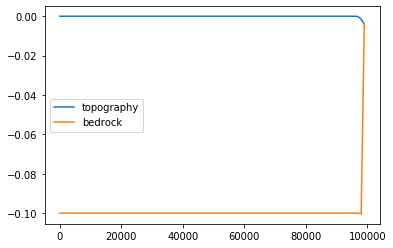

In [35]:
plt.plot(x, eta, label = 'topography')
plt.plot(x, etab, label = 'bedrock')
# plt.plot(x, H, label = 'sediment')
plt.legend()
plt.show()

In [ ]:
plt.plot(x, sedimentation_rate)
# plt.plot(x, bedrock_ero)
# plt.plot(x, total_ero)

In [ ]:
# plt.figure(figsize = (12, 8))

# plt.plot(x, H, label = 'sediment')
# # plt.plot(x, qs, label = 'sediment flux')
# plt.plot(x, etab_ev, label = 'bedrock')
# plt.title('abrasion effects on sed flux (default case)')
# plt.legend()

# # plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/abrasion_effects_sedflux_default.png')

# plt.show()

In [ ]:
# now see what happens if we tilt the downstream end up

In [ ]:
tilt_factor = np.linspace(1, 45, 100)

eta_tilt_ds = eta_ev + tilt_factor
etab_tilt_ds = etab_ev + tilt_factor
H_tilt_ds = H_ev + tilt_factor

In [ ]:
plt.plot(x, eta_ev, label = 'untilted')
plt.plot(x, eta_tilt_ds, label = 'downstream up')
# plt.plot(x, H_tilt)
plt.title('downstream-up tilted profile (defaults)')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/tilt_downstream_up_default.png')

plt.show()

In [ ]:
# now run the model to evolve the tilted topography

In [ ]:
S2, qs2, eta_ev2, etab_ev2, ero_plucking_ig2, ero_plucking_sed2, ero_ab_ig2, ero_ab_sed2, ero2, atr2, H_ev2 = two_lith_one_sed(x,
                                                                                                                          dx,
                                                                                                                          Hstar,
                                                                                                                          H_ev,
                                                                                                                          etab_tilt_ds,
                                                                                                                          eta_tilt_ds,
                                                                                                                          beta_ig,
                                                                                                                          beta_sed,
                                                                                                                          k_ig,
                                                                                                                          k_sed,
                                                                                                                          num_steps = 5000)

In [ ]:
# plt.figure(figsize = (12, 8))

plt.plot(x, etab_ev, label = 'pre tilt')
plt.plot(x, etab_ev2, label = 'post tilt')
plt.title('transient profile of downstream-up tilted')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/tilted_downstream_up_transient.png')

plt.show

In [ ]:
ero2

In [ ]:
# now see what happens if we tilt the upstream end up

In [ ]:
tilt_factor2 = np.linspace(45, 1, 100)

eta_tilt_us = eta_ev + tilt_factor2
etab_tilt_us = etab_ev + tilt_factor2
H_tilt_us = H_ev + tilt_factor2

In [ ]:
plt.plot(x, eta_ev, label = 'untilted')
plt.plot(x, eta_tilt_us, label = 'upstream up')
plt.title('upstream-up tilted profile (defaults)')
# plt.plot(x, H_tilt)
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/tilted_upstream_up_default.png')

plt.show()

In [ ]:
S3, qs3, eta_ev3, etab_ev3, ero_plucking_ig3, ero_plucking_sed3, ero_ab_ig3, ero_ab_sed3, ero3, atr3, H_ev3 = two_lith_one_sed(x,
                                                                                                                          dx,
                                                                                                                          Hstar,
                                                                                                                          H_ev,
                                                                                                                          etab_tilt_us,
                                                                                                                          eta_tilt_us,
                                                                                                                          beta_ig,
                                                                                                                          beta_sed,
                                                                                                                          k_ig,
                                                                                                                          k_sed,
                                                                                                                          num_steps = 1)

In [ ]:
plt.plot(x, etab_ev, label = 'pre tilt')
# plt.plot(x, etab_ev2, label = 'post tilt, downstream')
plt.plot(x, etab_ev3, label = 'post tilt, upstream')
plt.title('comparison of tilted and original profiles')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/tilted_upstream_up_transient.png')

plt.show

In [ ]:
# check out erosion rates 

plt.plot(x, ero, label = 'original')
# plt.plot(x, ero2, label = 'downstream-up')
plt.plot(x, ero3, label = 'upstream-up')
plt.title('erosion rate comparison')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_1_21 meeting/tilted_transient_erosion_rates.png')

plt.show()

In [ ]:
plt.plot(x[:-1], S, label = 'untilted')
plt.plot(x[:-1], S3, label = 'tilted upstream')
plt.title('slopes')
plt.legend()

In [ ]:
plt.plot(x, H_ev, label = 'untilted')
plt.plot(x, H_ev3, label = 'upstream tilt')
plt.title('soil profiles')
plt.legend()

In [ ]:
plt.plot(x, qs, label = 'untilted')
plt.plot(x, qs3, label = 'upstream tilt')
plt.title('sediment flux')
plt.legend()

In [ ]:
qs3